In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
pd.set_option('display.max_columns', None)
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#Importing the data
final_df=pd.DataFrame()
a_df=pd.DataFrame()
b_df=pd.DataFrame()
c_df=pd.DataFrame()

for file_n in os.listdir('listings'):
    if file_n[0]=='.':
        continue
    else:
        add_df = pd.read_csv(f'listings/{file_n}')
        if len(add_df.columns)==106:
            final_df = pd.concat([final_df, add_df], axis=0)
        elif len(add_df.columns)==96:
            a_df = pd.concat([a_df, add_df], axis=0)
        elif len(add_df.columns)==95:
            b_df = pd.concat([b_df, add_df], axis=0)
        else:
            c_df = pd.concat([c_df, add_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## Combining all 52 datasets, removing columns not present in all

In [3]:
#These are the columns not present in 2018 reports. They will be dropped.
not_in_2018 = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
       'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'number_of_reviews_ltm', 
       'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
       'calculated_host_listings_count_shared_rooms']
sf_df = final_df.drop(columns=not_in_2018)
sf_df = pd.concat([sf_df, a_df], axis=0)

#drop one column not in 2017
sf_df = sf_df.drop(columns=['is_business_travel_ready'])
sf_df = pd.concat([sf_df, b_df], axis=0)

#drop 3 columns not in 2016 & Prior
sf_df = sf_df.drop(columns=['access', 'interaction', 'house_rules'])
sf_df = pd.concat([sf_df, c_df], axis=0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


## Data Cleaning

In [4]:
pd.set_option('display.max_rows', 20)
#Converting Existing Data Columns to Dates
sf_df['last_scraped'] = pd.to_datetime(sf_df['last_scraped'])
sf_df['host_since'] = pd.to_datetime(sf_df['host_since'])
#Adding new date features
sf_df['year'] = sf_df['last_scraped'].transform(lambda x: x.year)
sf_df['month-year'] = sf_df['last_scraped'].transform(lambda x: f'{x.month} {x.year}')
sf_df['month'] = sf_df['last_scraped'].transform(lambda x: x.month)
sf_df['day_of_week'] = sf_df['last_scraped'].transform(lambda x: x.dt.dayofweek)
sf_df['day'] = sf_df['last_scraped'].transform(lambda x: x.day)

#Converting All Price Related Columns from Objects to Floats
sf_df['price'] = sf_df['price'].transform(lambda x: float(x.replace(',', '').replace('$', '')))
sf_df['extra_people'] = sf_df['extra_people'].transform(lambda x: float(x.replace(',', '').replace('$', '')))

#Fill NaNs in fee columns with 0's, because no additional fee, then convert
sf_df[['security_deposit','cleaning_fee']] = sf_df[['security_deposit','cleaning_fee']].fillna(int(0))
sf_df['security_deposit'] = sf_df['security_deposit'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))
sf_df['cleaning_fee'] = sf_df['cleaning_fee'].transform(lambda x: 0 if x==int(0) else float(x.replace(',', '').replace('$', '')))

#Dropping columns that have over 75% null
over_70_null = sf_df.columns[sf_df.isnull().sum()/len(sf_df) > 0.70]
sf_df = sf_df.drop(columns=over_70_null)

#Removing Outliers (0 & over 2000 daily rate)
outlier_thresh=2000
sf_df = sf_df.loc[~((sf_df['price'] == 0) | (sf_df['price'] > outlier_thresh))]

#Filling the NaNs in beds, bathrooms, bedrooms
#Assume that if the tenant has the full apartment, they have a bathroom/bedroom
cond1= (sf_df['room_type']=='Entire home/apt')
sf_df.loc[cond1 & (sf_df['beds']==0), sf_df.columns=='beds'] = 1
sf_df.loc[cond1 & (sf_df['bathrooms']==0), sf_df.columns=='bathrooms'] = 1
#For the rest, just fill na
sf_df[['beds','bathrooms', 'bedrooms']] = sf_df[['beds','bathrooms', 'bedrooms']].fillna(0)

#For review scores, let's just fillin with the average
review_lst = ['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']
for review in review_lst:
    sf_df[review] = sf_df[review].fillna(sf_df[review].mean())

## Train Test Split #1: Use 2015 - 2018 to predict 2019 & 2020

In [5]:
test_years=[2020,2019]
train_df = sf_df[~sf_df['year'].isin(test_years)]
test_df = sf_df[sf_df['year'].isin(test_years)]

## Dumb Model: Predicting the average list price for all

In [6]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
Xd = train_df[features]
yd = train_df['price']
X_train, X_val, y_train, y_val = train_test_split(Xd, yd, test_size=0.3)

In [7]:
average = np.mean(y_train)
preds_d = np.full(y_val.shape, average)
rmse = np.sqrt(mean_squared_error(preds_d, y_val))
rmse

210.8070326963888

## Baseline Models: No Parameter Tuning or Feature Engineering

In [8]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
X = train_df[features]
y = train_df['price'].apply(np.log)

In [9]:
X = pd.get_dummies(X, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [11]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                            0
neighbourhood_cleansed_Haight Ashbury    0
neighbourhood_cleansed_Inner Sunset      0
neighbourhood_cleansed_Lakeshore         0
neighbourhood_cleansed_Marina            0
                                        ..
property_type_Loft                       0
property_type_Other                      0
property_type_Pension (Korea)            0
property_type_Plane                      0
accommodates                             0
Length: 122, dtype: int64

In [12]:
estimator = LinearRegression()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6207283336198182, RMSE: 1.5305189856533918,
Cross Val Scores: [0.62022333 0.6198679  0.61867528]


In [13]:
estimator = DecisionTreeRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.8257791982625399, RMSE: 1.3343690671761133,
Cross Val Scores: [0.79327971 0.78127297 0.78985904]


In [14]:
estimator = RandomForestRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8847558463810982, RMSE: 1.2644130751378326,
Cross Val Scores: [0.86043456 0.85827839 0.86221697]


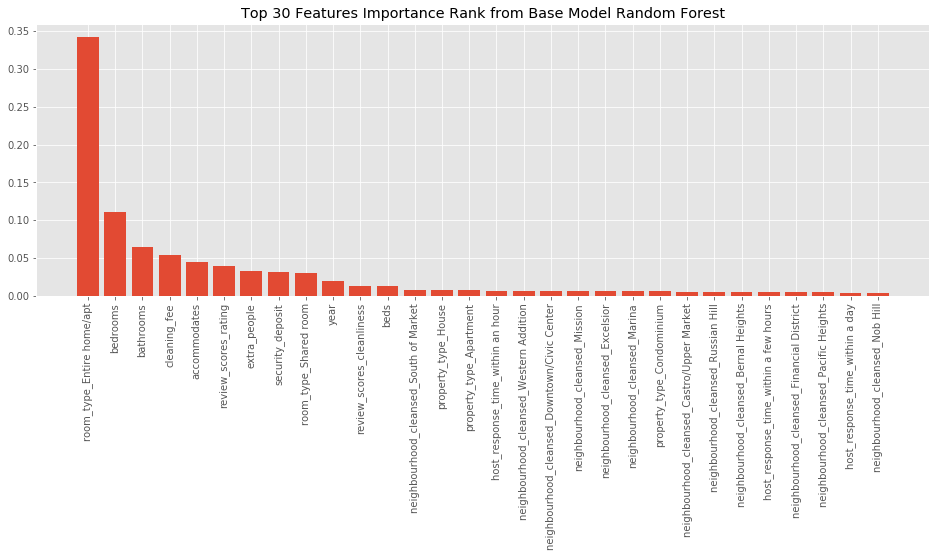

In [15]:
rf_features = X_train.columns
rf_feature_imp = model.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)

In [16]:
estimator = GradientBoostingRegressor()
model = estimator.fit(X_train,y_train)
preds = model.predict(X_val)
r2 = model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6618342547869625, RMSE: 1.4946345347457313,
Cross Val Scores: [0.66058459 0.66000688 0.66189041]


## Train Test Split Option 2: Randomized test group

In [17]:
train_df2, test = train_test_split(sf_df, test_size = 0.3)

## Test Dumb Model First

In [18]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week','year']
Xd = train_df2[features]
yd = train_df2['price']
X_train, X_val, y_train, y_val = train_test_split(Xd, yd, test_size=0.3)
average = np.mean(y_train)
preds_d = np.full(y_val.shape, average)
rmse = np.exp(np.sqrt(mean_squared_error(preds_d, y_val)))
rmse

2.688221359428333e+89

In [19]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 'year']
Xa = train_df2[features]
ya = train_df2['price'].apply(np.log)

Xa = pd.get_dummies(Xa, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(Xa, ya, test_size=0.3)

In [20]:
X_train.isnull().sum().sort_values(ascending=False)

day_of_week_6                       0
day_of_week_5                       0
neighbourhood_cleansed_Lakeshore    0
neighbourhood_cleansed_Marina       0
neighbourhood_cleansed_Mission      0
                                   ..
property_type_Loft                  0
property_type_Other                 0
property_type_Pension (Korea)       0
property_type_Plane                 0
accommodates                        0
Length: 128, dtype: int64

In [21]:
estimator = LinearRegression()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.6118580910728473, RMSE: 1.5372572196381717,
Cross Val Scores: [0.61082696 0.61809731 0.62005152]


In [22]:
estimator = DecisionTreeRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Scores: {cs_val}')

R2: 0.8206968406019448, RMSE: 1.3394490467824376,
Cross Val Scores: [0.78573215 0.7899847  0.79213003]


In [23]:
estimator = RandomForestRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, Xa, ya, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val),np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8827016142162633, RMSE: 1.2666612540071507,
Cross Val Score: (0.861395768040022, 0.8819915662351318)


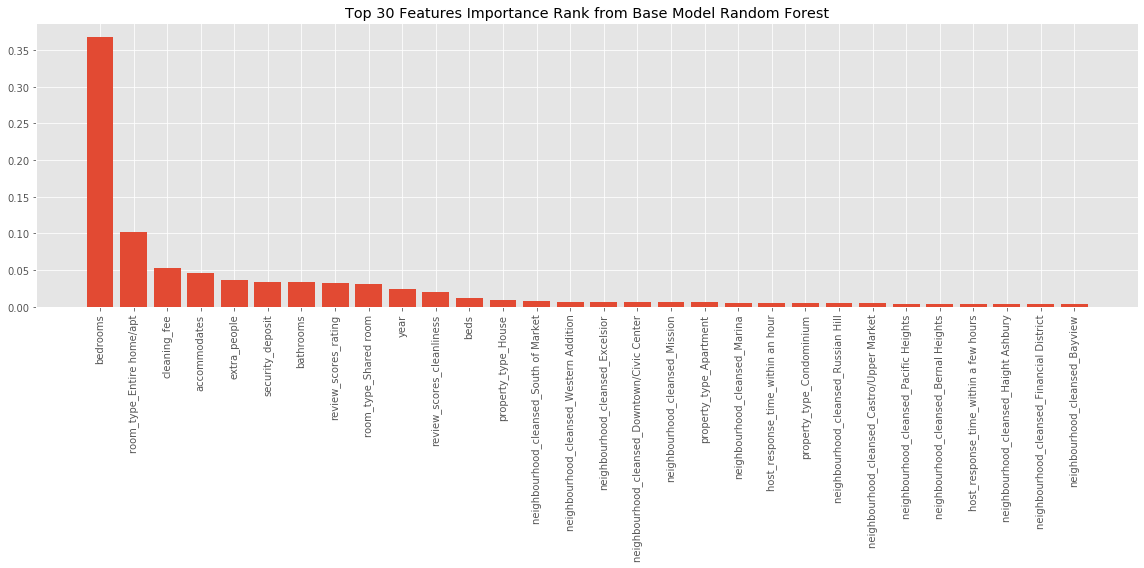

In [24]:
rf_features = X_train.columns
rf_feature_imp = modela.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Feature_imp_BaseModel_RF.png', dpi = 300)
plt.show()

In [25]:
estimator = GradientBoostingRegressor()
modela = estimator.fit(X_train,y_train)
preds = modela.predict(X_val)
r2 = modela.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nCross Val Score: {np.mean(cs_val)}')

R2: 0.6450179547766832, RMSE: 1.508660013186144,
Cross Val Score: 0.6513573898023141


## Model Iteration #1: Fee columns (Y or N) with random split

In [26]:
cols = ['has_deposit','has_cleaning_fee','extra_people_fee']

train_df2['has_deposit'] = train_df2['security_deposit'].transform(lambda x: 1 if x>0 else 0)
train_df2['has_cleaning_fee'] = train_df2['cleaning_fee'].transform(lambda x: 1 if x>0 else 0)
train_df2['extra_people_fee'] = train_df2['extra_people'].transform(lambda x: 1 if x>0 else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

In [27]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month','day_of_week', 'year',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X1 = train_df2[features]
y1 = train_df2['price'].apply(np.log)

X1 = pd.get_dummies(X1, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3)

In [28]:
estimator = RandomForestRegressor()
model1 = estimator.fit(X_train,y_train)
preds = model1.predict(X_val)
r2 = model1.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X1, y1, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8865534359122942, RMSE: 1.26184002420732,
Train Cross Val Score: 0.8604681674223569, Validation Cross Val Score: 0.8811694671191055


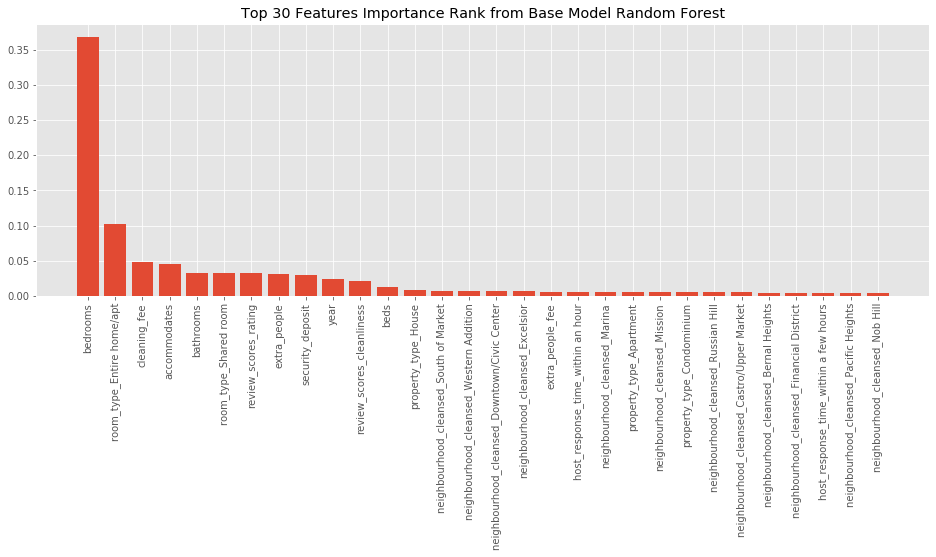

In [29]:
rf_features = X_train.columns
rf_feature_imp = model1.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

In [30]:
#Keep only Y or N column, remove the previous columns
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds', 'host_response_time','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'month','day_of_week', 'year',
          'has_cleaning_fee','has_deposit','extra_people_fee']
X1a = train_df2[features]
y1a = train_df2['price'].apply(np.log)

X1a = pd.get_dummies(X1a, columns=['bed_type','host_response_time', 
                           'neighbourhood_cleansed','property_type',
                           'room_type','month','day_of_week'])

X_train, X_val, y_train, y_val = train_test_split(X1a, y1a, test_size=0.3)

In [31]:
estimator = RandomForestRegressor()
model1a = estimator.fit(X_train,y_train)
preds = model1a.predict(X_val)
r2 = model1a.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X1a, y1a, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.848924113931661, RMSE: 1.3078141215166914,
Train Cross Val Score: 0.81750366287688, Validation Cross Val Score: 0.8414399313931296


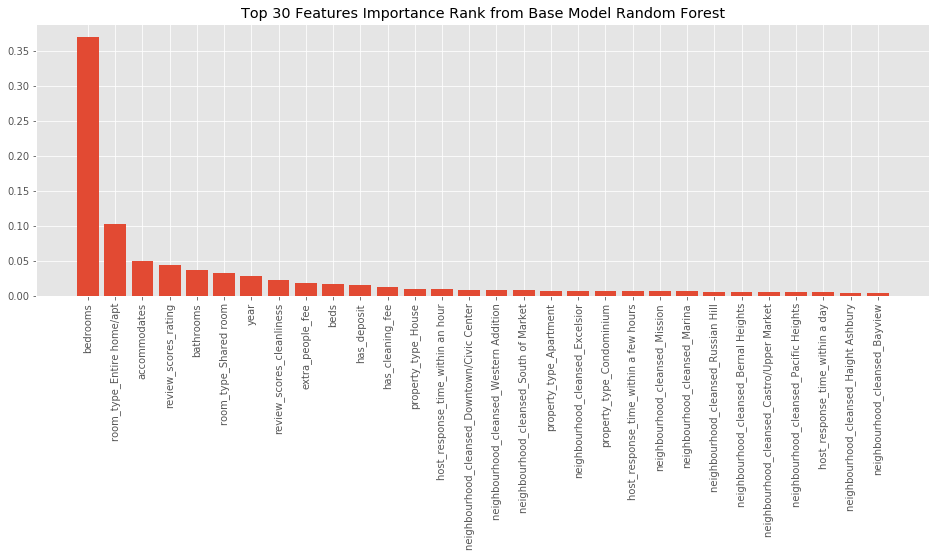

In [32]:
rf_features = X_train.columns
rf_feature_imp = model1a.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Base Model Random Forest')
plt.show()

## Model Iteration 2: Count of Amenities, random test/train/split

In [33]:
train_df2['amenities'] = train_df2['amenities'].fillna('0')
train_df2['num_amenities'] = train_df2['amenities'].transform(lambda x: len(x.split(',')))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X2 = train_df2[features]
y2 = train_df2['price'].apply(np.log)

X2 = pd.get_dummies(X2, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.3)

In [35]:
estimator = RandomForestRegressor()
model2 = estimator.fit(X_train,y_train)
preds = model2.predict(X_val)
r2 = model2.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X2, y2, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.91372334016961, RMSE: 1.2237568153003688,
Train Cross Val Score: 0.8870845601241175, Validation Cross Val Score: 0.9081897604178851


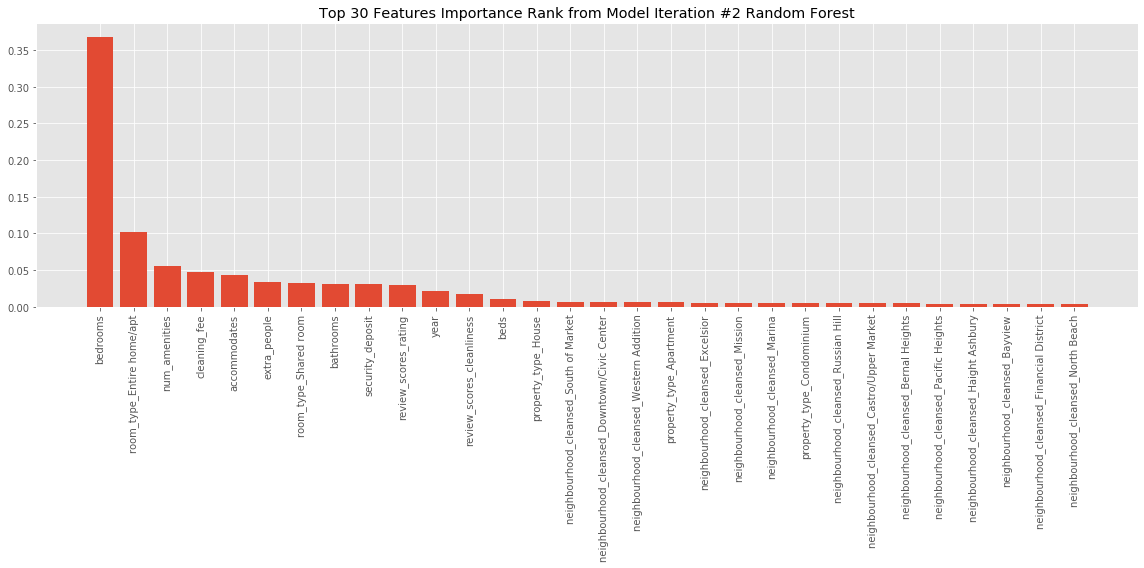

In [36]:
rf_features = X_train.columns
rf_feature_imp = model2.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/num_amenities_imp.png', dpi=300)
plt.show()

## Model Iteration 3: Indicate when property is over a threshold in terms of accommodation features (accomodates, #bedrooms, #bathrooms, #beds)

In [37]:
accom_thresh = 12
bedroom_thresh = 6
bathroom_thresh = 6 #or could be 3?
beds_thresh = 9
train_df2['over_accm'] = train_df2['accommodates'].transform(lambda x: 1 if x>accom_thresh else 0)
train_df2['over_bdrm'] = train_df2['bedrooms'].transform(lambda x: 1 if x>bedroom_thresh else 0)
train_df2['over_btrm'] = train_df2['bathrooms'].transform(lambda x: 1 if x>bathroom_thresh else 0)
train_df2['over_beds'] = train_df2['beds'].transform(lambda x: 1 if x>beds_thresh else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [38]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities', 'over_accm','over_bdrm','over_btrm', 'over_beds',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X3 = train_df2[features]
y3 = train_df2['price'].apply(np.log)

X3 = pd.get_dummies(X3, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X3, y3, test_size=0.3)

In [39]:
estimator = RandomForestRegressor()
model3 = estimator.fit(X_train,y_train)
preds = model3.predict(X_val)
r2 = model3.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X3, y3, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.9098270725385412, RMSE: 1.2303041275986846,
Train Cross Val Score: 0.8889700901926448, Validation Cross Val Score: 0.908761527991754


In [48]:
rf_features = X_train.columns
rf_feature_imp = model3.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #3 Random Forest')
plt.show()

ValueError: Shape of passed values is (122, 1), indices imply (16, 1)

## Model Iteration 4: Regions

In [41]:
Northeast = ["Mission", "Western Addition", "South Of Market", "Castro/Upper Market,"
             "Downtown/Civic Center", "Haight Ashbury", "Nob Hill", "Marina", "Pacific Heights",
            "Russian Hill", "North Beach", "Financial District", "Chinatown", "Presidio Heights"]
Southeast = ["Bernal Heights", "Noe Valley", "Potrero Hill", "Excelsior", "Bayview", "Glen Park", 
             "Visitacion Valley," "Crocker Amazon", "Diamond Heights"]
Northwest = ["Inner Richmond", "Outer Sunset", "Outer Richmond", "Inner Sunset", "Twin Peaks", 
             "Seacliff", "Golden Gate Park", "Presidio"]
Southwest = ["Outer Mission", "Parkside", "West of Twin Peaks", "Ocean View", "Lakeshore"]
Other = ["Treasure Island/YBI"]

def region(x):
    if x in Northeast:
        return 'Northeast'
    elif x in Southeast:
        return 'Southeast'
    elif x in Northwest:
        return "Northwest"
    elif x in Southwest:
        return "Southwest"
    else:
        return "Other"
train_df2['Region'] = train_df2['neighbourhood_cleansed'].apply(region)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities',
         'Region','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X4 = train_df2[features]
y4 = train_df2['price'].apply(np.log)

X4 = pd.get_dummies(X4, columns=['bed_type','Region','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X4, y4, test_size=0.3)

In [43]:
estimator = RandomForestRegressor()
model4 = estimator.fit(X_train,y_train)
preds = model4.predict(X_val)
r2 = model4.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X4, y4, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8905667491137823, RMSE: 1.2567828857136643,
Train Cross Val Score: 0.8655475780933606, Validation Cross Val Score: 0.8876664006247955


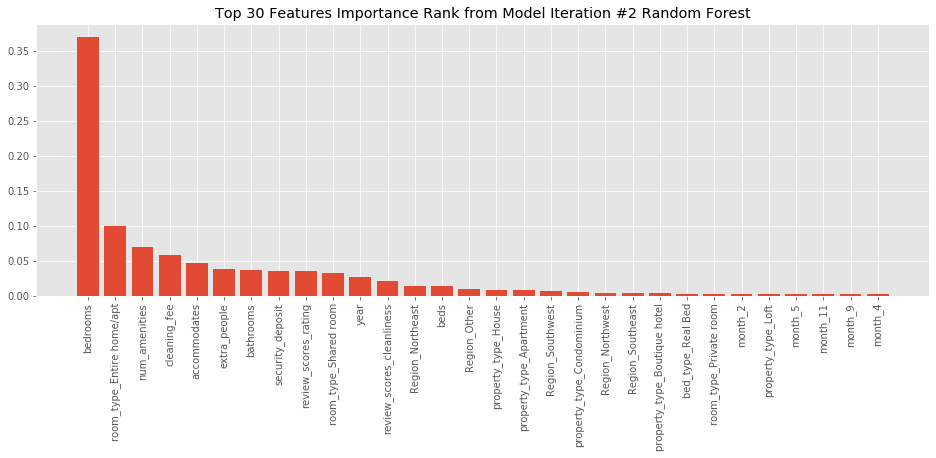

In [44]:
rf_features = X_train.columns
rf_feature_imp = model4.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 5: Downtown or not

In [45]:
downtown = ["Western Addition", "South Of Market", "Downtown/Civic Center", 
                    "Financial District"]
train_df2['Downtown'] = train_df2['neighbourhood_cleansed'].transform(lambda x: 1 if x in downtown else 0)

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year',
         'Downtown']
X5 = train_df2[features]
y5 = train_df2['price'].apply(np.log)

X5 = pd.get_dummies(X5, columns=['bed_type','property_type',
                           'room_type','month'])

X_train, X_val, y_train, y_val = train_test_split(X5, y5, test_size=0.3)

In [50]:
estimator = RandomForestRegressor()
model5 = estimator.fit(X_train,y_train)
preds = model5.predict(X_val)
r2 = model5.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X5, y5, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.8759521057845634, RMSE: 1.274130201531357,
Train Cross Val Score: 0.849056138349617, Validation Cross Val Score: 0.8744443915192649


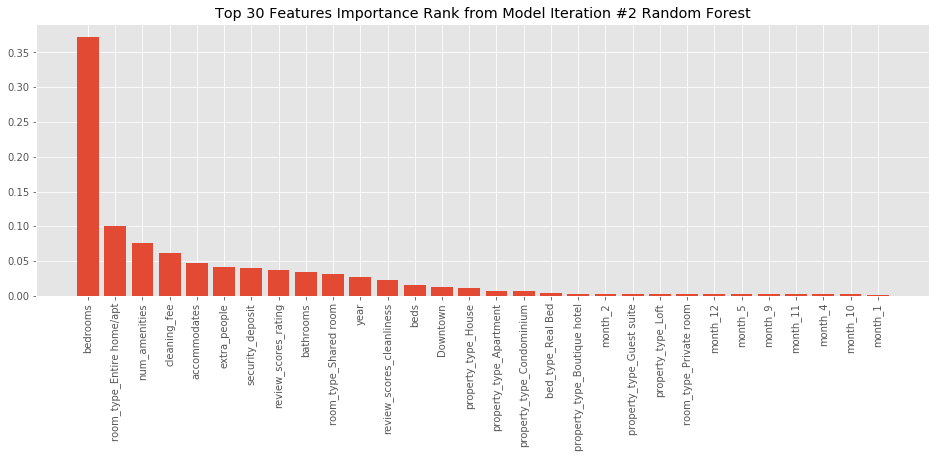

In [51]:
rf_features = X_train.columns
rf_feature_imp = model5.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 6: Apartment or Shared Room, Property Type: House Only

In [52]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities',
         'neighbourhood_cleansed','property_type','review_scores_cleanliness',
          'review_scores_rating', 'room_type', 'security_deposit', 'month', 'year']
X6 = train_df2[features]
y6 = train_df2['price'].apply(np.log)

X6 = pd.get_dummies(X6, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

In [53]:
X6 = X6.drop(columns=['room_type_Hotel room', 'room_type_Private room'])

In [54]:
X6.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'extra_people', 'num_amenities', 'review_scores_cleanliness',
       'review_scores_rating', 'security_deposit',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=116)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X6, y6, test_size=0.3)

In [56]:
estimator = RandomForestRegressor()
model6 = estimator.fit(X_train,y_train)
preds = model6.predict(X_val)
r2 = model6.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X6, y6, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.9104513579027183, RMSE: 1.2301929359501447,
Train Cross Val Score: 0.8882022328627127, Validation Cross Val Score: 0.9086562504004908


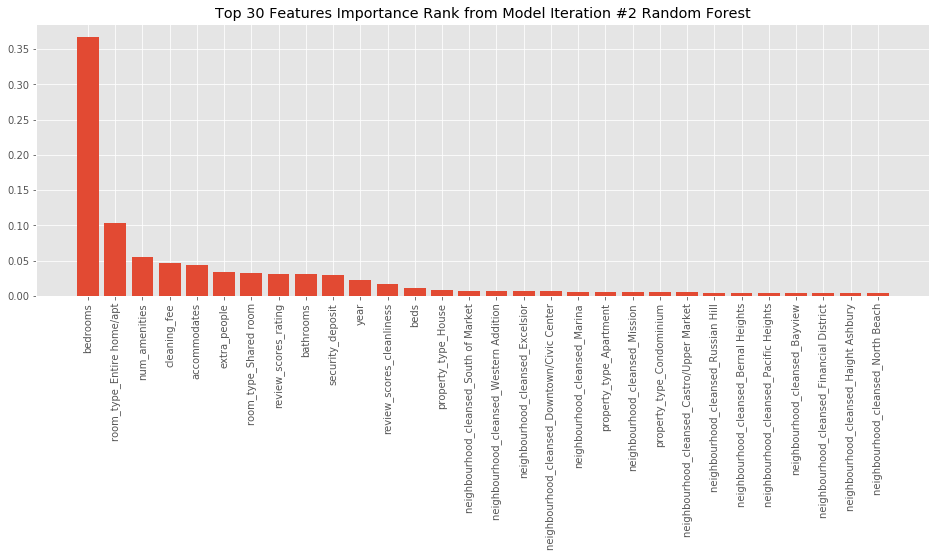

In [57]:
rf_features = X_train.columns
rf_feature_imp = model6.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

In [58]:
#Remove all property types but house
X6a = X6.drop(columns=['property_type_Aparthotel',
       'property_type_Barn', 'property_type_Bed & Breakfast',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Boutique hotel', 'property_type_Bungalow',
       'property_type_Bus', 'property_type_Cabin', 'property_type_Camper/RV',
       'property_type_Casa particular', 'property_type_Castle',
       'property_type_Cave', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Cycladic house (Greece)', 'property_type_Dome house',
       'property_type_Dorm', 'property_type_Earth House',
       'property_type_Earth house', 'property_type_Entire Floor',
       'property_type_Farm stay', 'property_type_Floor',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_Hotel',
       'property_type_Hut', 'property_type_In-law', 'property_type_Island',
       'property_type_Lighthouse', 'property_type_Loft', 'property_type_Other',
       'property_type_Pension (Korea)', 'property_type_Plane',
       'property_type_Resort', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Timeshare',
       'property_type_Tiny house', 'property_type_Tipi',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Vacation home', 'property_type_Villa',
       'property_type_Yurt'])

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X6a, y6, test_size=0.3)

In [60]:
estimator = RandomForestRegressor()
model6a = estimator.fit(X_train,y_train)
preds = model6a.predict(X_val)
r2 = model6a.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X6a, y6, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.9100239832241727, RMSE: 1.2297580030298436,
Train Cross Val Score: 0.8861904609406911, Validation Cross Val Score: 0.9060030774050252


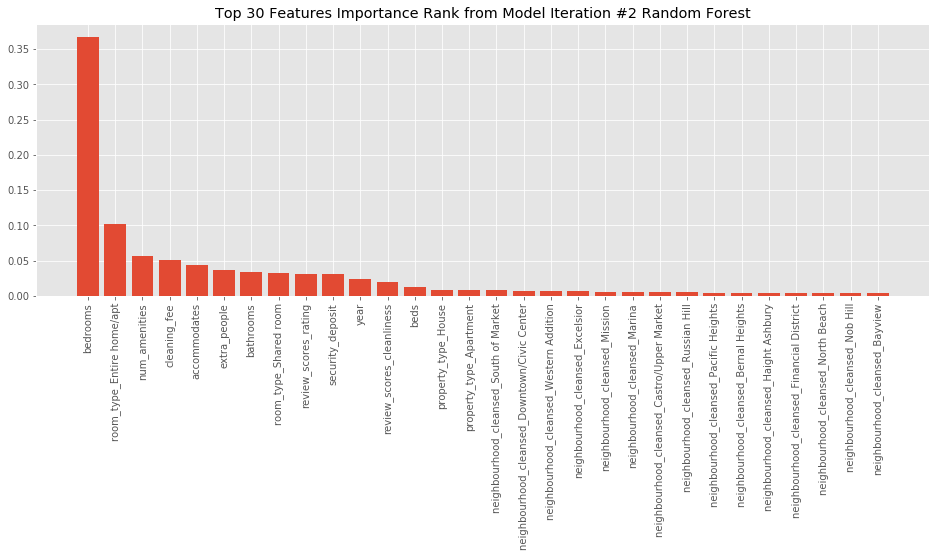

In [61]:
rf_features = X_train.columns
rf_feature_imp = model6a.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,5))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #2 Random Forest')
plt.show()

## Iteration 7: Adding Text Lengths

In [64]:
train_df2[['space','summary','description','name']] = train_df2[['space','summary','description','name']].fillna('0')
train_df2['len_space'] = train_df2['space'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_summary'] = train_df2['summary'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_description'] = train_df2['description'].transform(lambda x: 0 if x=='0' else len(x))
train_df2['len_name'] = train_df2['name'].transform(lambda x: 0 if x=='0' else len(x))

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sherryduong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [96]:
features=['accommodates','bathrooms', 'bed_type','bedrooms', 'beds','cleaning_fee',
          'extra_people', 'num_amenities','neighbourhood_cleansed','property_type',
          'review_scores_cleanliness','len_space', 'len_summary', 'len_description',
          'len_name', 'review_scores_rating', 'room_type', 'security_deposit', 'month', 
          'year']
X7 = train_df2[features]
y7 = train_df2['price'].apply(np.log)

X7 = pd.get_dummies(X7, columns=['bed_type','neighbourhood_cleansed','property_type',
                           'room_type','month'])

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X7, y7, test_size=0.3)

In [67]:
estimator = RandomForestRegressor()
model7 = estimator.fit(X_train,y_train)
preds = model7.predict(X_val)
r2 = model7.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X7, y7, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')

/Users/sherryduong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2: 0.9326647196586775, RMSE: 1.1954101944936686,
Train Cross Val Score: 0.910127307939506, Validation Cross Val Score: 0.9289097675704726


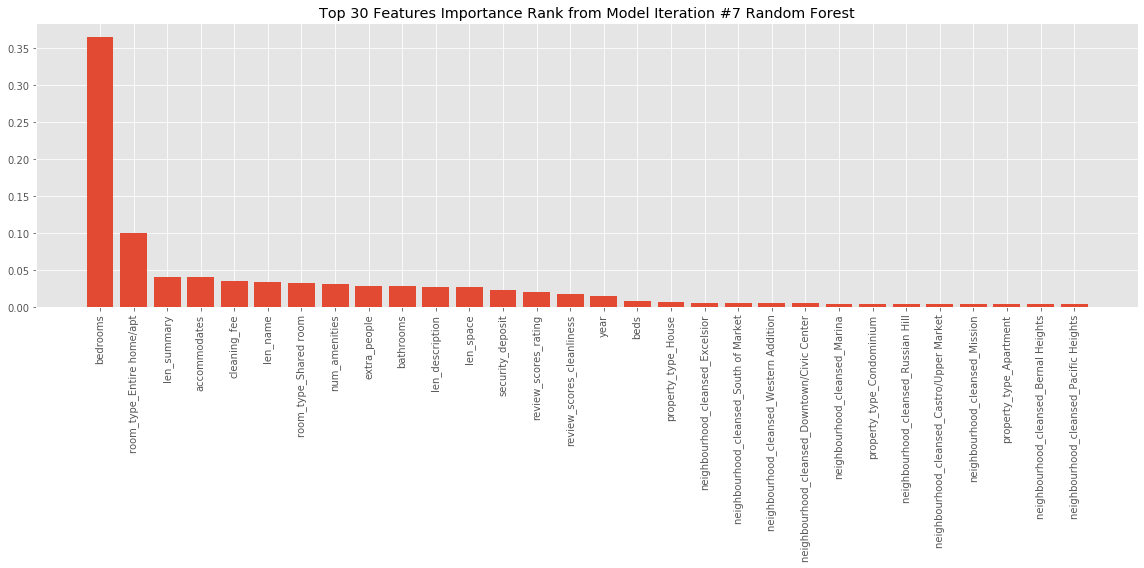

In [70]:
rf_features = X_train.columns
rf_feature_imp = model7.feature_importances_
feat_df = pd.DataFrame(rf_feature_imp, index=rf_features, 
                       columns=['weight']).sort_values('weight',ascending=False)[:30]
plt.figure(figsize=(16,8))
plt.bar(x=feat_df.index, height=feat_df['weight'])
plt.xticks(rotation=90)
plt.title('Top 30 Features Importance Rank from Model Iteration #7 Random Forest')
plt.tight_layout()
# plt.savefig('Graphs/Length_text_feat_imp.png', dpi=300)
plt.show()

## Grid Search CV Iteration 7

In [84]:
from sklearn.model_selection import GridSearchCV

In [87]:
param_grid = {'n_estimators' : np.arange(100,500,100),
              'max_features' : [5,30,55,80,105,122]}
grid_search = GridSearchCV(estimator, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_features': 80, 'min_samples_split': 27487, 'n_estimators': 400}
0.5259998013859657


In [ ]:
estimator = RandomForestRegressor(max_features= 80, 
                                  n_estimators= 400)
model7 = estimator.fit(X_train,y_train)
preds = model7.predict(X_val)
r2 = model7.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(preds, y_val))
cs_val = cross_val_score(estimator, X_train, y_train, cv=3)
cs_val2 = cross_val_score(estimator, X7, y7, cv=3)
print(f'R2: {r2}, RMSE: {np.exp(rmse)},\nTrain Cross Val Score: {np.mean(cs_val)}, Validation Cross Val Score: {np.mean(cs_val2)}')